# Imports

In [171]:
# Systems
import warnings

# Data Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Analysis
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [172]:
# Ignore warnings 
warnings.filterwarnings('ignore')

# Data

In [173]:
df = pd.read_csv('../data/processed/hypothesis_testing.csv')
df.head(3)

,channel_character,published_at,duration,category_name,view_count,like_count,title,description
0,Pinkfong,2024-12-26 19:00:38,128.883333,Education,9152,33.0,[BEST🏆] 언제 어디서나! 가족과 함께 듣는 핑크퐁 인기 동요 메들리🎶 | +모...,★ 다음은 이 노래를 들어볼까? : https://youtu.be/ueWyQgzjQ...
1,Pinkfong,2024-12-25 10:00:05,0.166667,Education,40776,1113.0,종소리 울려라~🔔 오늘은 크리스마스에요! #크리스마스 #핑크퐁,★ 다음은 이 노래를 들어볼까? : https://www.youtube.com/wa...
2,Pinkfong,2024-12-25 10:00:02,180.216667,Education,23468,71.0,[TV📺] 울면 안 돼~ 오늘은 크리스마스에요! | 핑크퐁 아기상어 BEST 캐럴 ...,★ 다음은 이 노래를 들어볼까? : https://www.youtube.com/wa...


## Filter outliers by channel

In [174]:
def remove_outlier_iqr(df, cols):
	for col in cols:
		q3 = df[col].quantile(.75)
		q1 = df[col].quantile(.25)
		
		iqr = q3 - q1
		
		upper_bound = q3 + (1.5 * iqr)
		lower_bound = q1 - (1.5 * iqr)
		mask_normal = (df[col] >= lower_bound) & (df[col] <= upper_bound)
		
		df = df.loc[mask_normal]
	
	return df

In [175]:
df_filtered = pd.DataFrame()

for channel in df['channel_character'].unique():
    df_channel = df[df['channel_character'] == channel]
    df_channel = remove_outlier_iqr(df_channel, ['view_count'])
    
    df_filtered = pd.concat([df_filtered, df_channel], ignore_index=True)
    
df_filtered.head(3)
    

,channel_character,published_at,duration,category_name,view_count,like_count,title,description
0,Pinkfong,2024-12-26 19:00:38,128.883333,Education,9152,33.0,[BEST🏆] 언제 어디서나! 가족과 함께 듣는 핑크퐁 인기 동요 메들리🎶 | +모...,★ 다음은 이 노래를 들어볼까? : https://youtu.be/ueWyQgzjQ...
1,Pinkfong,2024-12-25 10:00:05,0.166667,Education,40776,1113.0,종소리 울려라~🔔 오늘은 크리스마스에요! #크리스마스 #핑크퐁,★ 다음은 이 노래를 들어볼까? : https://www.youtube.com/wa...
2,Pinkfong,2024-12-25 10:00:02,180.216667,Education,23468,71.0,[TV📺] 울면 안 돼~ 오늘은 크리스마스에요! | 핑크퐁 아기상어 BEST 캐럴 ...,★ 다음은 이 노래를 들어볼까? : https://www.youtube.com/wa...


# Functions used for Hypothesis Testing

In [176]:
def check_normality(series):
    # Perform the Shapiro-Wilk test
    _, p_value = stats.shapiro(series)

    # Print the results
    print(f"P-value: {p_value}")

    # Interpretation
    if p_value > 0.05:
        print("The data appears to be normally distributed (fail to reject H0).")
    else:
        print("The data does not appear to be normally distributed (reject H0).")

# Hypothesis Testing

## Temporal Trends

In [177]:
df_temporal_trends = df_filtered.copy()
df_temporal_trends = df_temporal_trends[['channel_character', 'published_at', 'view_count']]

# Convert the 'published_at' column to datetime
df_temporal_trends['published_at'] = pd.to_datetime(df_temporal_trends['published_at'])

# Make day_of_week column
df_temporal_trends['day_of_week'] = df_temporal_trends['published_at'].dt.day_name()

# Make time_of_day column
df_temporal_trends['hour'] = df_temporal_trends['published_at'].dt.hour

# Separate the data for each channel
df_pinkfong_temporal = df_temporal_trends.loc[df_temporal_trends['channel_character'] == 'Pinkfong', ['day_of_week', 'hour', 'view_count']]
df_ollie_temporal = df_temporal_trends.loc[df_temporal_trends['channel_character'] == 'Ollie', ['day_of_week', 'hour', 'view_count']]
df_bebefinn_temporal = df_temporal_trends.loc[df_temporal_trends['channel_character'] == 'Bebefinn', ['day_of_week', 'hour', 'view_count']]

### Which day of the week is it better to upload? (ANOVA)

$H_0$: There is no difference in views across days of the week.

$H_1$: There is a difference in views across days of the week.

Check for normality of data.

In [178]:
# Check for normality of data in Pinkfong's days
for day in df_pinkfong_temporal['day_of_week'].unique():
    df_day = df_pinkfong_temporal[df_pinkfong_temporal['day_of_week'] == day]
    print(f"Day: {day}\n")
    try:
        check_normality(df_day['view_count'])
    except ValueError:
        print("Insufficient data to perform Shapiro-Wilk test.")
    print()
    
# Check for normality of data in Ollie's days
for day in df_ollie_temporal['day_of_week'].unique():
    df_day = df_ollie_temporal[df_ollie_temporal['day_of_week'] == day]
    print(f"Day: {day}\n")
    try:
        check_normality(df_day['view_count'])
    except ValueError:
        print("Insufficient data to perform Shapiro-Wilk test.")
    print()
    
# Check for normality of data in Bebefinn's days
for day in df_bebefinn_temporal['day_of_week'].unique():
    df_day = df_bebefinn_temporal[df_bebefinn_temporal['day_of_week'] == day]
    print(f"Day: {day}\n")
    try:
        check_normality(df_day['view_count'])
    except ValueError:
        print("Insufficient data to perform Shapiro-Wilk test.")
    print()


Day: Thursday

P-value: 1.3678777249011399e-27
The data does not appear to be normally distributed (reject H0).

Day: Wednesday

P-value: 2.0364563422975817e-28
The data does not appear to be normally distributed (reject H0).

Day: Tuesday

P-value: 4.330448305078533e-28
The data does not appear to be normally distributed (reject H0).

Day: Sunday

P-value: 9.162152905102167e-27
The data does not appear to be normally distributed (reject H0).

Day: Saturday

P-value: 1.3676257277256979e-23
The data does not appear to be normally distributed (reject H0).

Day: Friday

P-value: 1.278239595012871e-25
The data does not appear to be normally distributed (reject H0).

Day: Monday

P-value: 1.673886192538892e-25
The data does not appear to be normally distributed (reject H0).

Day: Friday

P-value: 3.07645733473878e-15
The data does not appear to be normally distributed (reject H0).

Day: Wednesday

P-value: 1.347987934765315e-19
The data does not appear to be normally distributed (reject H0)

There is no data that is normally distributed:

- All channels have non-normal data so Kruskal-Wallis test is the appropriate test choice.

Day of Week Hypothesis testing for Pinkfong

In [179]:
# Group the data by 'day_of_week' and extract the 'view_count' values for each group
groups = [group['view_count'].values for _, group in df_pinkfong_temporal.groupby('day_of_week')]

# Perform the Kruskal-Wallis H-test
_, p = stats.kruskal(*groups)

# Print the Kruskal-Wallis results
print(f'Kruskal-Wallis p-value: {p}')

if p < 0.05:
    print("Reject the null hypothesis: The two groups have different distributions.")
    posthoc_result = pairwise_tukeyhsd(
        endog=df_pinkfong_temporal['view_count'], 
        groups=df_pinkfong_temporal['day_of_week'],
        alpha=0.05
    )

    # Convert the result to a DataFrame and display
    posthoc_df = pd.DataFrame(data=posthoc_result.summary().data[1:], columns=posthoc_result.summary().data[0])
    print(f"Post-Hoc results:\n{posthoc_df}")
else:
    print("Fail to reject the null hypothesis: No significant difference in distributions.")

Kruskal-Wallis p-value: 3.41098114394081e-31
Reject the null hypothesis: The two groups have different distributions.
Post-Hoc results:
      group1     group2     meandiff   p-adj        lower        upper  reject
0     Friday     Monday -190756.8642  0.0000 -278636.8778 -102876.8506    True
1     Friday   Saturday   33250.0538  0.8629  -43597.3995  110097.5071   False
2     Friday     Sunday  -69735.0630  0.1150 -147716.7889    8246.6630   False
3     Friday   Thursday -108606.1535  0.0009 -187135.2658  -30077.0411    True
4     Friday    Tuesday -153005.7763  0.0000 -233700.0313  -72311.5213    True
5     Friday  Wednesday -117283.3884  0.0001 -192134.7749  -42432.0019    True
6     Monday   Saturday  224006.9180  0.0000  136029.9417  311983.8944    True
7     Monday     Sunday  121021.8013  0.0012   32052.3297  209991.2729    True
8     Monday   Thursday   82150.7108  0.0962   -7298.9331  171600.3546   False
9     Monday    Tuesday   37751.0880  0.8870  -53605.2478  129107.4237   F

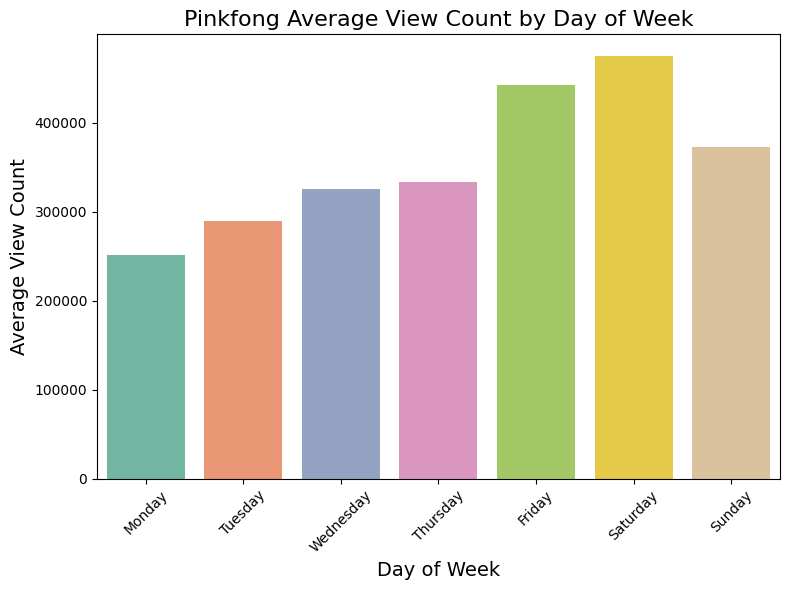

In [180]:
# Calculate the average view_count per day_of_week
df_avg_view_count = df_pinkfong_temporal.groupby('day_of_week')['view_count'].mean().reset_index()

# Sort the data by day_of_week
# Correct order of the days from Monday to Sunday
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Reorder the day_of_week column to ensure proper sorting for the heatmap
df_avg_view_count['day_of_week'] = pd.Categorical(df_avg_view_count['day_of_week'], categories=weekday_order, ordered=True)

# Plot the bar graph
plt.figure(figsize=(8, 6))
sns.barplot(data=df_avg_view_count, x='day_of_week', y='view_count', palette='Set2')
plt.title('Pinkfong Average View Count by Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Average View Count', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Day of week Hypothesis testing for Ollie

In [181]:
# Group the data by 'day_of_week' and extract the 'view_count' values for each group
groups = [group['view_count'].values for _, group in df_ollie_temporal.groupby('day_of_week')]

# Perform the Kruskal-Wallis H-test
_, p = stats.kruskal(*groups)

# Print the Kruskal-Wallis results
print(f'Kruskal-Wallis p-value: {p}')

if p < 0.05:
    print("Reject the null hypothesis: The two groups have different distributions.")
    posthoc_result = pairwise_tukeyhsd(
        endog=df_ollie_temporal['view_count'], 
        groups=df_ollie_temporal['day_of_week'],
        alpha=0.05
    )

    # Convert the result to a DataFrame and display
    posthoc_df = pd.DataFrame(data=posthoc_result.summary().data[1:], columns=posthoc_result.summary().data[0])
    print(f"Post-Hoc results:\n{posthoc_df}")
else:
    print("Fail to reject the null hypothesis: No significant difference in distributions.")

Kruskal-Wallis p-value: 1.6811400627867632e-12
Reject the null hypothesis: The two groups have different distributions.
Post-Hoc results:
      group1     group2    meandiff   p-adj        lower        upper  reject
0     Friday     Monday -38966.1053  0.4077  -96174.6291   18242.4185   False
1     Friday   Saturday  27057.4130  0.4975  -15564.2336   69679.0596   False
2     Friday     Sunday   8107.4892  0.9979  -34715.5986   50930.5771   False
3     Friday   Thursday -38956.9967  0.1407  -83968.6970    6054.7035   False
4     Friday    Tuesday -14885.1203  0.9688  -62466.5527   32696.3121   False
5     Friday  Wednesday -46505.4786  0.0270  -89977.3254   -3033.6318    True
6     Monday   Saturday  66023.5183  0.0104    9502.4408  122544.5959    True
7     Monday     Sunday  47073.5946  0.1777   -9599.5411  103746.7302   False
8     Monday   Thursday      9.1086  1.0000  -58335.3908   58353.6080   False
9     Monday    Tuesday  24080.9850  0.9023  -36268.1671   84430.1371   False
10  

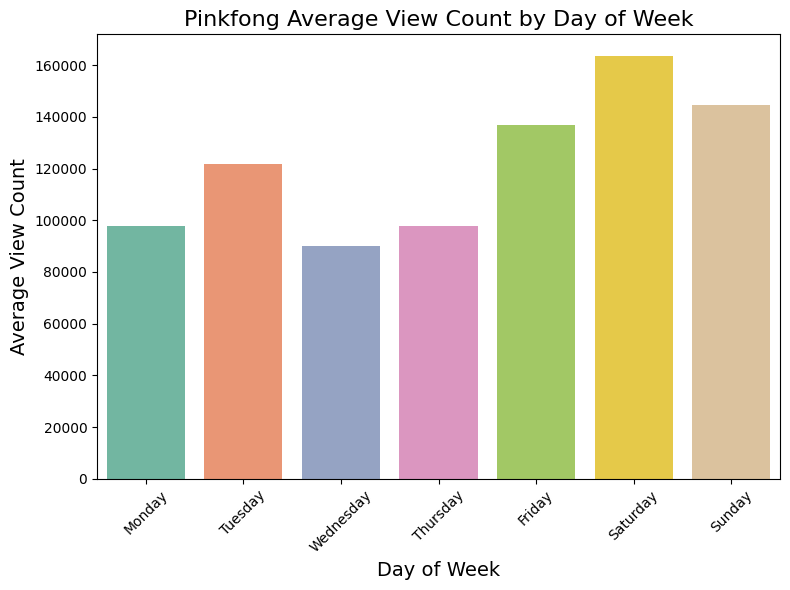

In [182]:
# Calculate the average view_count per day_of_week
df_avg_view_count = df_ollie_temporal.groupby('day_of_week')['view_count'].mean().reset_index()

# Sort the data by day_of_week
# Correct order of the days from Monday to Sunday
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Reorder the day_of_week column to ensure proper sorting for the heatmap
df_avg_view_count['day_of_week'] = pd.Categorical(df_avg_view_count['day_of_week'], categories=weekday_order, ordered=True)

# Plot the bar graph
plt.figure(figsize=(8, 6))
sns.barplot(data=df_avg_view_count, x='day_of_week', y='view_count', palette='Set2')
plt.title('Pinkfong Average View Count by Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Average View Count', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Day of week Hypothesis testing for Bebefinn

In [183]:
# Group the data by 'day_of_week' and extract the 'view_count' values for each group
groups = [group['view_count'].values for _, group in df_bebefinn_temporal.groupby('day_of_week')]

# Perform the Kruskal-Wallis H-test
_, p = stats.kruskal(*groups)

# Print the Kruskal-Wallis results
print(f'Kruskal-Wallis p-value: {p}')

if p < 0.05:
    print("Reject the null hypothesis: The two groups have different distributions.")
    posthoc_result = pairwise_tukeyhsd(
        endog=df_bebefinn_temporal['view_count'], 
        groups=df_bebefinn_temporal['day_of_week'],
        alpha=0.05
    )

    # Convert the result to a DataFrame and display
    posthoc_df = pd.DataFrame(data=posthoc_result.summary().data[1:], columns=posthoc_result.summary().data[0])
    print(f"Post-Hoc results:\n{posthoc_df}")
else:
    print("Fail to reject the null hypothesis: No significant difference in distributions.")
    
posthoc_df

Kruskal-Wallis p-value: 8.402365899694434e-17
Reject the null hypothesis: The two groups have different distributions.
Post-Hoc results:
      group1     group2     meandiff   p-adj        lower         upper  \
0     Friday     Monday -129728.1417  0.8123 -407809.1577  1.483529e+05   
1     Friday   Saturday  275546.5359  0.0480    1347.8346  5.497452e+05   
2     Friday     Sunday -159804.9330  0.9279 -589380.5800  2.697707e+05   
3     Friday   Thursday  441487.3794  0.0001  154603.1967  7.283716e+05   
4     Friday    Tuesday  274326.6850  0.0704  -11991.8427  5.606452e+05   
5     Friday  Wednesday  -20723.4221  1.0000 -326232.0644  2.847852e+05   
6     Monday   Saturday  405274.6776  0.0000  178428.9837  6.321204e+05   
7     Monday     Sunday  -30076.7913  1.0000 -431087.1123  3.709335e+05   
8     Monday   Thursday  571215.5211  0.0000  329189.5404  8.132415e+05   
9     Monday    Tuesday  404054.8267  0.0000  162699.6106  6.454100e+05   
10    Monday  Wednesday  109004.7196  

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Friday,Monday,-129728.1417,0.8123,-407809.1577,1.483529e+05,False
1,Friday,Saturday,275546.5359,0.0480,1347.8346,5.497452e+05,True
2,Friday,Sunday,-159804.9330,0.9279,-589380.5800,2.697707e+05,False
3,Friday,Thursday,441487.3794,0.0001,154603.1967,7.283716e+05,True
4,Friday,Tuesday,274326.6850,0.0704,-11991.8427,5.606452e+05,False
5,Friday,Wednesday,-20723.4221,1.0000,-326232.0644,2.847852e+05,False
6,Monday,Saturday,405274.6776,0.0000,178428.9837,6.321204e+05,True
7,Monday,Sunday,-30076.7913,1.0000,-431087.1123,3.709335e+05,False
8,Monday,Thursday,571215.5211,0.0000,329189.5404,8.132415e+05,True
9,Monday,Tuesday,404054.8267,0.0000,162699.6106,6.454100e+05,True


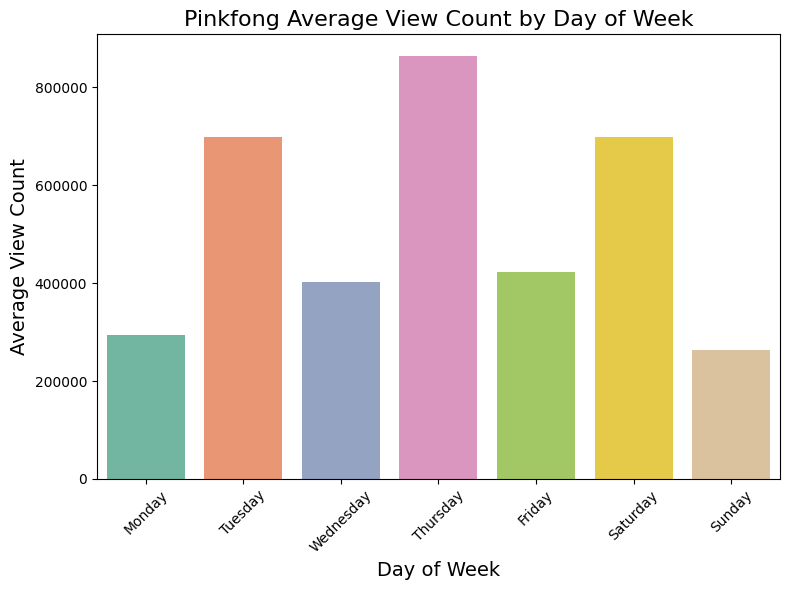

In [184]:
# Calculate the average view_count per day_of_week
df_avg_view_count = df_bebefinn_temporal.groupby('day_of_week')['view_count'].mean().reset_index()

# Sort the data by day_of_week
# Correct order of the days from Monday to Sunday
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Reorder the day_of_week column to ensure proper sorting for the heatmap
df_avg_view_count['day_of_week'] = pd.Categorical(df_avg_view_count['day_of_week'], categories=weekday_order, ordered=True)

# Plot the bar graph
plt.figure(figsize=(8, 6))
sns.barplot(data=df_avg_view_count, x='day_of_week', y='view_count', palette='Set2')
plt.title('Pinkfong Average View Count by Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Average View Count', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Results: Day of the Week (ANOVA)

Pinkfong: Friday and Saturday have significantly more views than the other days. There is no significant difference between the other days.

Ollie: Friday, Saturday, and Sunday seem to have more views than other days, but the differences are not that clear. Although the pattern is similar to Pinkfong where there seems to be a trend to peak towards Saturday (which was significantly different with many of the weekdays).

Bebefinn: Tuesday, Thursday, Saturday have significantly more views than the other days. There is no significant difference between the other days. However, for Bebefinn, Monday is the day with most uploads but stil Tuesday has more views on average so it would be good to instead upload in one of these three days (Tuesday, Thursday, Saturday).

### Which hour of the day is it better to upload? (t-test)

$H_0$: There is no difference in views between hours of the day.

$H_1$: There is a difference in views between hours of the day.

Check for data for each hour of the day.

In [185]:
print('Pinkfong hours:')
print(df_pinkfong_temporal['hour'].value_counts())

print()

print('Ollie hours:')
print(df_ollie_temporal['hour'].value_counts())

print()

print('Bebefinn hours:')
print(df_bebefinn_temporal['hour'].value_counts())

Pinkfong hours:
hour
19    1607
10     542
17     461
18     251
9      170
13      91
20      49
14      38
11      34
21      22
15      19
12      18
16      11
7        5
8        5
22       3
5        2
6        1
0        1
2        1
1        1
Name: count, dtype: int64

Ollie hours:
hour
19    853
10    192
18     64
20     13
21     13
9       8
8       6
15      4
14      3
17      3
12      2
16      2
13      1
0       1
7       1
Name: count, dtype: int64

Bebefinn hours:
hour
19    558
20     13
10      6
7       4
8       2
2       1
9       1
0       1
12      1
14      1
11      1
21      1
18      1
Name: count, dtype: int64


All in all, most of the upload times for all channels are either 10am or 7pm (10:00 and 19:00). So these are the two groups that will be compared for the channels.

Check for normality of data.

In [186]:
# Check for normality of data in Pinkfong's hours
for hour in [10, 19]:
    df_hour = df_pinkfong_temporal[df_pinkfong_temporal['hour'] == hour]
    print(f"Hour: {hour}\n")
    try:
        check_normality(df_hour['view_count'])
    except ValueError:
        print("Insufficient data to perform Shapiro-Wilk test.")
    print()
    
# Check for normality of data in Ollie's hours
for hour in [10, 19]:
    df_hour = df_ollie_temporal[df_ollie_temporal['hour'] == hour]
    print(f"Hour: {hour}\n")
    try:
        check_normality(df_hour['view_count'])
    except ValueError:
        print("Insufficient data to perform Shapiro-Wilk test.")
    print()
    
# Check for normality of data in Bebefinn's hours
for hour in [10, 19]:
    df_hour = df_bebefinn_temporal[df_bebefinn_temporal['hour'] == hour]
    print(f"Hour: {hour}\n")
    try:
        check_normality(df_hour['view_count'])
    except ValueError:
        print("Insufficient data to perform Shapiro-Wilk test.")
    print()


Hour: 10

P-value: 4.7098855557304266e-30
The data does not appear to be normally distributed (reject H0).

Hour: 19

P-value: 4.233718920752333e-46
The data does not appear to be normally distributed (reject H0).

Hour: 10

P-value: 8.269213815137765e-15
The data does not appear to be normally distributed (reject H0).

Hour: 19

P-value: 8.481888188642478e-35
The data does not appear to be normally distributed (reject H0).

Hour: 10

P-value: 0.15955510236336629
The data appears to be normally distributed (fail to reject H0).

Hour: 19

P-value: 5.4385192243195096e-27
The data does not appear to be normally distributed (reject H0).



The data don't appear to be normally distributed (only 10am for Bebefinn but it has too view values). That's why a non-parametric test will be used.

Time of day Hypothesis testing for Pinkfong

In [187]:
# Separate the data for each category for Pinkfong Channel
df_pinkfong_10 = df_pinkfong_temporal[df_pinkfong_temporal['hour'] == 10]
df_pinkfong_19 = df_pinkfong_temporal[df_pinkfong_temporal['hour'] == 19]

# Perform Mann-Whitney U test for each category in Pinkfong Channel
_, p = stats.mannwhitneyu(
    df_pinkfong_10['view_count'], 
    df_pinkfong_19['view_count']
)
print(f"Pinkfong hours Mann-Whitney U:\n p-value:{p}")

# Interpret the p-value
alpha = 0.05
if p < alpha:
    print("Reject the null hypothesis: The two groups have different distributions.")
else:
    print("Fail to reject the null hypothesis: No significant difference in distributions.")


Pinkfong hours Mann-Whitney U:
 p-value:0.27829237632411075
Fail to reject the null hypothesis: No significant difference in distributions.


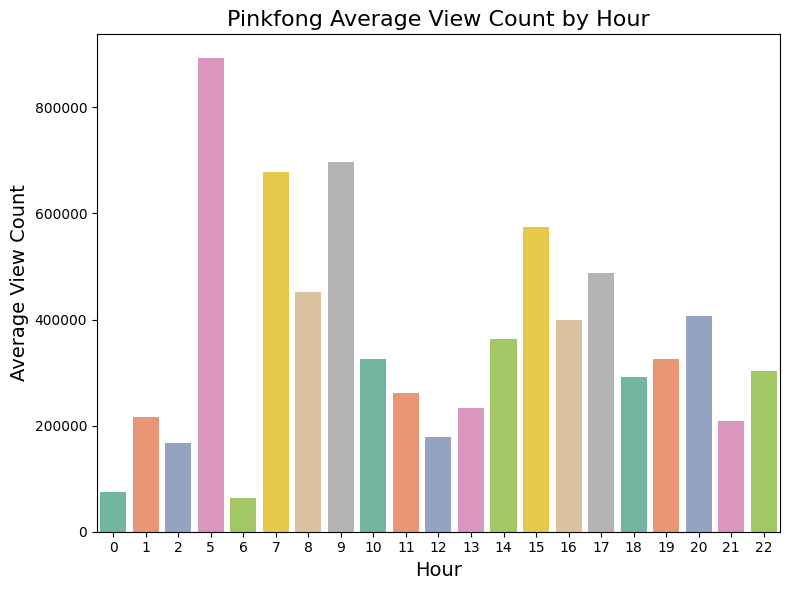

In [188]:
# Bar plot the average view_count for hour 10 and 19 for Pinkfong Channel

# Calculate the average view_count per hour
df_avg_view_count = df_pinkfong_temporal.groupby('hour')['view_count'].mean().reset_index()

# Plot the bar graph
plt.figure(figsize=(8, 6))
sns.barplot(data=df_avg_view_count, x='hour', y='view_count', palette='Set2')
plt.title('Pinkfong Average View Count by Hour', fontsize=16)
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Average View Count', fontsize=14)
plt.tight_layout()
plt.show()

Time of day Hypothesis testing for Ollie

In [189]:
# Separate the data for each category for Ollie Channel
df_ollie_10 = df_ollie_temporal[df_ollie_temporal['hour'] == 10]
df_ollie_19 = df_ollie_temporal[df_ollie_temporal['hour'] == 19]

# Perform Mann-Whitney U test for each category in Ollie Channel
_, p = stats.mannwhitneyu(
    df_ollie_10['view_count'],
    df_ollie_19['view_count']
)
print(f"Ollie hours Mann-Whitney U:\n p-value:{p}")

# Interpret the p-value
alpha = 0.05
if p < alpha:
    print("Reject the null hypothesis: The two groups have different distributions.")
else:
    print("Fail to reject the null hypothesis: No significant difference in distributions.")

Ollie hours Mann-Whitney U:
 p-value:0.010934899139714856
Reject the null hypothesis: The two groups have different distributions.


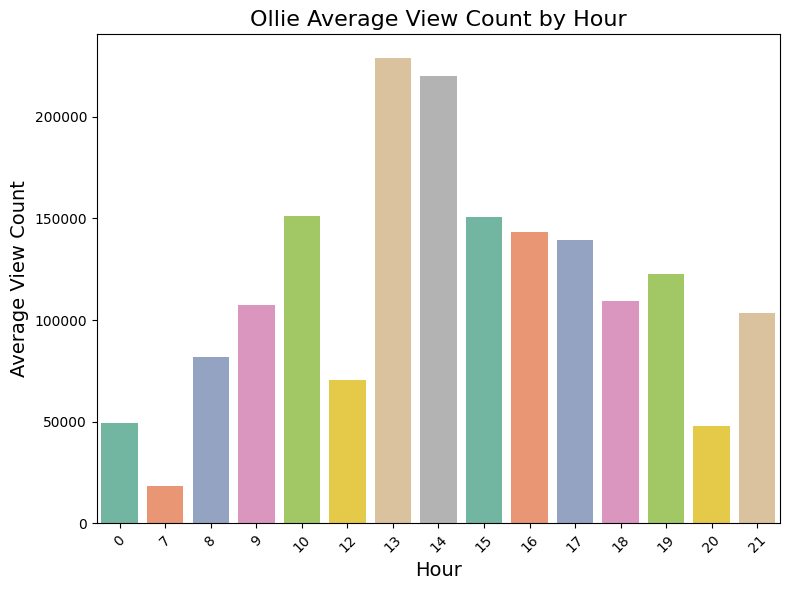

In [190]:
# Bar plot the average view_count for hour 10 and 19 for Ollie Channel

# Calculate the average view_count per hour
df_avg_view_count = df_ollie_temporal.groupby('hour')['view_count'].mean().reset_index()

# Plot the bar graph
plt.figure(figsize=(8, 6))
sns.barplot(data=df_avg_view_count, x='hour', y='view_count', palette='Set2')
plt.title('Ollie Average View Count by Hour', fontsize=16)
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Average View Count', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Time of day Hypothesis testing for Bebefinn

In [191]:
# Separate the data for each category for Bebefinn Channel
df_bebefinn_10 = df_bebefinn_temporal[df_bebefinn_temporal['hour'] == 10]
df_bebefinn_19 = df_bebefinn_temporal[df_bebefinn_temporal['hour'] == 19]

# Perform Mann-Whitney U test for each category in Bebefinn Channel
_, p = stats.mannwhitneyu(
    df_bebefinn_10['view_count'],
    df_bebefinn_19['view_count']
)
print(f"Bebefinn hours Mann-Whitney U:\n p-value:{p}")

# Interpret the p-value 
alpha = 0.05
if p < alpha:
    print("Reject the null hypothesis: The two groups have different distributions.")
else:
    print("Fail to reject the null hypothesis: No significant difference in distributions.")

Bebefinn hours Mann-Whitney U:
 p-value:0.7747094270120629
Fail to reject the null hypothesis: No significant difference in distributions.


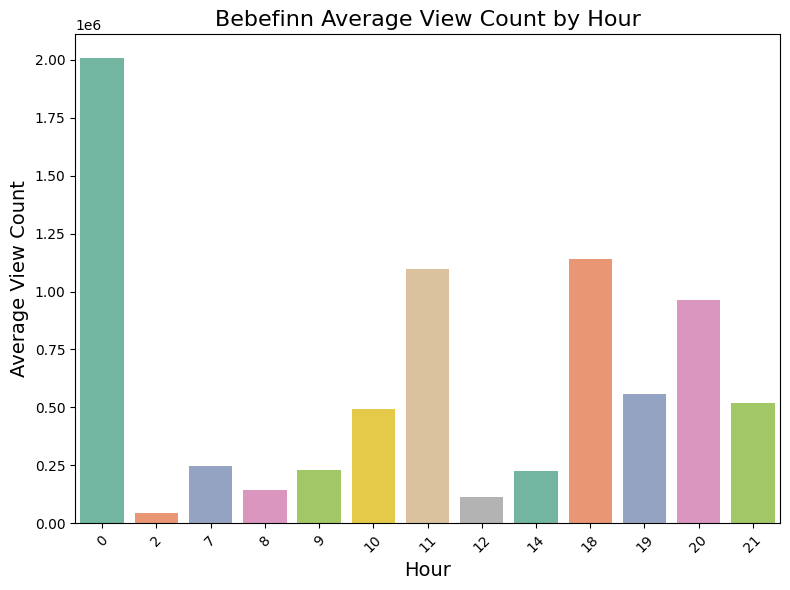

In [192]:
# Bar plot the average view_count for hour 10 and 19 for Bebefinn Channel

# Calculate the average view_count per hour
df_avg_view_count = df_bebefinn_temporal.groupby('hour')['view_count'].mean().reset_index()

# Plot the bar graph    
plt.figure(figsize=(8, 6))
sns.barplot(data=df_avg_view_count, x='hour', y='view_count', palette='Set2')
plt.title('Bebefinn Average View Count by Hour', fontsize=16)
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Average View Count', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Results: Time of Day (t-test)

Ollie was the only channel with a significant difference in views between 10am and 19am. 

Pinkfong and Bebefinn did not show a significant difference in views between 10am and 19am.

However, by looking at the different averages of views per hour, it could be said that even though it is fewer, videos with earlier upload times tend to have more views.

This could mean that instead of uploading mostly at 19:00, the upload times could be halved or mostly moved to an earlier time of the day like 09:00 or 10:00.

## Comparative Analysis

### Which category is it better to upload? (ANOVA)

$H_0$: There is no difference in views across categories.

$H_1$: There is a difference in views across categories.

In [193]:
df_category_performance = df_filtered.copy()
df_category_performance = df_category_performance[['channel_character', 'category_name', 'view_count']]
df_category_performance.head(5)

,channel_character,category_name,view_count
0,Pinkfong,Education,9152
1,Pinkfong,Education,40776
2,Pinkfong,Education,23468
3,Pinkfong,Education,8974
4,Pinkfong,Education,201126


Check for normality of data

In [194]:
for channel in ['Pinkfong', 'Ollie']:
    df_channel = df_category_performance[df_category_performance['channel_character'] == channel]
    print(f"Channel: {channel}\n")
    
    for category in df_channel['category_name'].unique():
        df_category = df_channel[df_channel['category_name'] == category]
        print(f"Category: {category}\n")
        try:
            check_normality(df_category['view_count'])
        except ValueError:
            print("Insufficient data to perform Shapiro-Wilk test.")
        print()

Channel: Pinkfong

Category: Education

P-value: 2.144649838405022e-57
The data does not appear to be normally distributed (reject H0).

Category: Pets & Animals

P-value: 0.9648436781886464
The data appears to be normally distributed (fail to reject H0).

Category: Entertainment

P-value: 1.1495543688763417e-08
The data does not appear to be normally distributed (reject H0).

Category: Sports

Insufficient data to perform Shapiro-Wilk test.

Category: Gaming

P-value: 0.16820068787384676
The data appears to be normally distributed (fail to reject H0).

Category: Film & Animation

Insufficient data to perform Shapiro-Wilk test.

Category: People & Blogs

Insufficient data to perform Shapiro-Wilk test.

Channel: Ollie

Category: Entertainment

P-value: 2.635155121632535e-31
The data does not appear to be normally distributed (reject H0).

Category: Film & Animation

P-value: 3.2331476094565966e-26
The data does not appear to be normally distributed (reject H0).

Category: Gaming

Insuff

Check for data for each category.

In [195]:
print('Pinkfong categories:')
print(df_category_performance.loc[df_category_performance['channel_character'] == 'Pinkfong', 'category_name'].value_counts())

print('\nOllie categories:')
print(df_category_performance.loc[df_category_performance['channel_character'] == 'Ollie', 'category_name'].value_counts())

Pinkfong categories:
category_name
Education           3246
Entertainment         76
Pets & Animals         3
Gaming                 3
Film & Animation       2
Sports                 1
People & Blogs         1
Name: count, dtype: int64

Ollie categories:
category_name
Entertainment       700
Film & Animation    462
Gaming                2
Education             2
Name: count, dtype: int64


There are many categories that have insufficient data, so first, those categories will be removed.

Pinkfong: Education, Pets & Animals, Entertainment, Gaming

Ollie: Entertainment, Films & Animation

In [196]:
df_pinkfong_categories = (
    df_category_performance
    .loc[
        (df_category_performance['channel_character'] == 'Pinkfong') &
        (df_category_performance['category_name'].isin(['Education', 'Entertainment']))
    ]
)

df_ollie_categories = (
    df_category_performance
    .loc[
        (df_category_performance['channel_character'] == 'Ollie') &
        (df_category_performance['category_name'].isin(['Entertainment', 'Film & Animation']))
    ]
)

print(df_pinkfong_categories['category_name'].unique())
print(df_ollie_categories['category_name'].unique())

['Education' 'Entertainment']
['Entertainment' 'Film & Animation']


There is no data that is normally distributed:

- ANOVA for Pinkfong will be performed with a non-parametric test: Kruskal-Wallis test.
- t-test for Ollie will be performed with a non-parametric test: Mann-Whitney U test.

In [197]:
# Separate the data for each category for Pinkfong Channel
df_pinkfong_education = df_pinkfong_categories[df_pinkfong_categories['category_name'] == 'Education']
df_pinkfong_entertainment = df_pinkfong_categories[df_pinkfong_categories['category_name'] == 'Entertainment']

# Perform Kruskal-Wallis test for each category in Pinkfong Channel
_, p = stats.mannwhitneyu(
    df_pinkfong_education['view_count'], 
    df_pinkfong_entertainment['view_count'], 
)
print(f"Pinkfong categories Mann-Whitney U:\n p-value:{p}")

# Interpret the p-value
alpha = 0.05
if p < alpha:
    print("Reject the null hypothesis: The two groups have different distributions.")
else:
    print("Fail to reject the null hypothesis: No significant difference in distributions.")

Pinkfong categories Mann-Whitney U:
 p-value:0.34448312275153037
Fail to reject the null hypothesis: No significant difference in distributions.


In [198]:
# Separate the data for each category for Ollie Channel
df_ollie_entertainment = df_ollie_categories[df_ollie_categories['category_name'] == 'Entertainment']
df_ollie_films = df_ollie_categories[df_ollie_categories['category_name'] == 'Film & Animation']

# Perform Mann-Whitney U test for each category in Ollie Channel
_, p = stats.mannwhitneyu(
    df_ollie_entertainment['view_count'], 
    df_ollie_films['view_count']
)
print(f"Ollie categories Mann-Whitney U:\n p-value:{p}")

# Interpret the p-value
alpha = 0.05
if p < alpha:
    print("Reject the null hypothesis: The two groups have different distributions.")
else:
    print("Fail to reject the null hypothesis: No significant difference in distributions.")

Ollie categories Mann-Whitney U:
 p-value:0.5816650363983238
Fail to reject the null hypothesis: No significant difference in distributions.


Because there was no significant differences across the categories in both channels, some metrics can also be defined to reflect the performance of each category to help with the comparison for data imbalance:

•	View rate: Total views divided by the total number of videos in each category.

$\text{View Rate (VR)} = \frac{\text{Total Views in Category}}{\text{Number of Videos in Category}}$

•	Proportion of videos: Distribution of videos across categories (imbalanced data).

$\text{Proportion (P)} = \frac{\text{Number of Videos in Category}}{\text{Total Videos}}$

Combine the two metrics above to make a KPI:  

$\text{KPI} = \text{Proportion (P)} \cdot \text{View Rate}$


In [199]:
df_kpi = df_category_performance.copy()
df_kpi = df_kpi.loc[df_kpi['channel_character'].isin(['Pinkfong', 'Ollie'])].reset_index(drop=True)

# Calculate the metrics
df_kpi['total_views_in_category'] = (
    df_kpi
    .groupby(['channel_character', 'category_name'])['view_count']
    .transform('sum')
)

df_kpi['number_of_videos_in_category'] = (
    df_kpi
    .groupby(['channel_character', 'category_name'])['view_count']
    .transform('count')
)

df_kpi['total_videos'] = (
    df_kpi
    .groupby('channel_character')['view_count']
    .transform('count')
)

# Calculate the view_rate
df_kpi['view_rate'] = (
    df_kpi['total_views_in_category'] / 
    df_kpi['number_of_videos_in_category']
)

# Calculate the proportion
df_kpi['proportion'] = (
    df_kpi['number_of_videos_in_category'] / 
    df_kpi['total_videos']
)

df_kpi['kpi'] = (
    df_kpi['view_rate'] *
    df_kpi['proportion']
)

df_kpi_results = (
    df_kpi
    .drop_duplicates(subset=['channel_character', 'category_name'])
    .reset_index(drop=True)
    [['channel_character', 'category_name', 'number_of_videos_in_category', 'kpi']]
    .rename(columns={'number_of_videos_in_category': 'video_count'})
)
df_kpi_results

,channel_character,category_name,video_count,kpi
0,Pinkfong,Education,3246,354335.181273
1,Pinkfong,Pets & Animals,3,672.978691
2,Pinkfong,Entertainment,76,7872.927071
3,Pinkfong,Sports,1,127.889556
4,Pinkfong,Gaming,3,378.386255
5,Pinkfong,Film & Animation,2,82.316927
6,Pinkfong,People & Blogs,1,14.583133
7,Ollie,Entertainment,700,76283.198971
8,Ollie,Film & Animation,462,48870.560034
9,Ollie,Gaming,2,31.386792


#### Results: Category (Mann-Whitney U)

Considering the number of videos in each categories for all three channels:

- Pinkfong categories Mann-Whitney U: there were only two categories that were worth comparing (Education and Entertainment). There was no significant difference in the view rates.

- Ollie categories Mann-Whitney U: there were only two categories that were worth comparing (Entertainment and Films & Animation). There was no significant difference in the view rates.

- Bebefinn was excluded because it has only one category.

When comparing the KPIs, the dataframe: `df_kpi_results` might be useful in a dashboard to track the performance of each category.

save the results to a CSV file

In [200]:
df_kpi_save = (
    df_kpi
    .drop(columns=['view_count'])
    .rename(columns=
        {
            'total_views_in_category': 'view_count_category',
            'number_of_videos_in_category': 'video_count_category',
            'total_videos': 'video_count_total'
        }
    )
    .drop_duplicates(subset=['channel_character', 'category_name'])
    .reset_index(drop=True)
)
df_kpi_save.to_csv('../data/tableau/kpi.csv', header=True, index=False)